# TAGRAI: Thematic Analysis of Genre using AI

## Introduction

Humans don’t usually need to be told the genre of a movie - we **infer** it naturally through **context**, **patterns** and **past experiences**. Even a short plot summary gives us enough clues to make educated guesses.

We subconsciously pick up on **keywords**, **themes**, **emotions** and **narrative tropes**. For example:

- *"After losing his family in a tragic accident, a man retreats to the wilderness and learns to survive."*  
  - Likely **Adventure**, maybe **Drama**

- *"A young girl stumbles upon a cursed mirror that shows her a dark version of herself."*  
  - Sounds like **Horror**, **Mystery**, **Thriller**

- *"Two mismatched cops must team up to stop a bank heist on Christmas Eve."*  
  - Probably **Action**, maybe **Comedy** or **Buddy Cop**

---

### What Clues Do Humans Use?

Humans rely on a mix of subtle and familiar cues:

- **Lexical cues**: Words like _"curse"_, _"revenge"_, _"love"_, _"haunted"_
- **Emotional tone**:  
  - _Tragic_ --> **Drama**  
  - _Light-hearted_ --> **Comedy**
- **Narrative structure**:  
  - _hero’s journey_ --> **Adventure**  
  - _mysterious_ --> **Mystery**
- **Cultural tropes**:  
  - _Mismatched partners_ --> **Buddy Cop**  
  - _Apocalypse or AI takeover_ --> **Sci-Fi**

---

> **So can a machine guess a movie’s genre just by reading its plot?**

This project explores that very question.

---

### Project Goal

The aim is to build an **end-to-end machine learning pipeline** that can predict one or more genres of a movie based solely on its **plot synopsis**.

Most movies follow recognizable **patterns**:
- a love triangle may suggest **Romance**
- a car chase hints at **Action**
- a haunted house screams **Horror**.  

This project attempts to detect and learn those patterns using **Natural Language Processing (NLP)** and **Multi-label Classification**.

---

## Data Collection

The data for this project has been collected from [IMDB's public dump](https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset/), [The IMDB Bollywood movies dataset](https://www.kaggle.com/datasets/anoopjohny/the-imdb-bollywood-movies-dataset) and [Metadata on ~5,000 movies from TMDb](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata). IMDB contains data on approximately ~5 million movies. But just for this project we are going to work with ~50k movies for learning purposes.

---

### Purpose

Our first source of data comes from IMDB's public data dump file ([title.basics.tsv](https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset/?select=title.basics.tsv)). For extracting useful data from this I wrote a script [`genreplot_harvester.py`](../Scripts/genreplot_harvester.py) where my goal is to:
1. Read IMDb movie titles from `title.basics.tsv` (official IMDb dataset)
2. Fetch each movie’s plot and genres using IMDbPY
3. Store results in `raw_data.csv` while supporting resume after interruption
4. Run in **parallel (multi-threaded)** to speed up scraping
5. Save intermediate progress using pickle files and logs

---
<!-- 
### Step-by-Step Walkthrough

#### 1. Imports
```python
import os
import pickle
import pandas as pd
from imdb import IMDb
import time
import csv
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock
from tqdm import tqdm
```

- `os`: File path handling.
- `pickle`: Store Python objects (e.g., titles, movie data) for resume.
- `pandas`: Load IMDb TSV and CSV files.
- `IMDb (IMDbPY)`: Library for fetching IMDb movie details.
- `ThreadPoolExecutor`: Enables concurrent requests.
- `Lock`: Prevents multiple threads from writing to the same file/data at the same time.
- `tqdm`: Progress bar for user feedback.

#### 2. Config

```python
TOP_N = 5320016  # Number of movies to scrape = 5320016 (This is the maximum amount)
THREADS = 4
RETRY_LIMIT = 3
DELAY_RANGE = (0.8, 1.4)

TITLE_CACHE = "DATA/cache/titles.pkl"
MOVIE_CACHE = "DATA/cache/movie_cache.pkl"
PROGRESS_LOG = "DATA/cache/progress.log"
RAW_CSV = "DATA/raw/raw_data.csv"
TSV_PATH = "DATA/raw/title.basics.tsv"
```

Here we initialize the filepaths and variables to be used later on.  
> **NOTE**: Caching paths allow resuming scraping without starting over.

#### 3. Directory checks

```python
# Ensure directories exist
os.makedirs("DATA/cache", exist_ok=True)
os.makedirs("DATA/raw", exist_ok=True)

# Check for TSV existence
if not os.path.exists(TSV_PATH):
    raise FileNotFoundError(f"Missing required TSV file: {TSV_PATH}")
```

Ensures directories exist and stops execution if the IMDb dataset is missing.

#### 4. Loading Titles

```python
if os.path.exists(TITLE_CACHE):
    print("Loading cached titles...")
    with open(TITLE_CACHE, "rb") as f:
        top_titles = pickle.load(f)
else:
    print("Reading IMDb TSV file...")
    df = pd.read_csv(TSV_PATH, sep='\t', low_memory=False)
    movies = df[df['titleType'] == 'movie'][['tconst', 'primaryTitle']].dropna().reset_index(drop=True)
    top_titles = movies.head(TOP_N)
    with open(TITLE_CACHE, "wb") as f:
        pickle.dump(top_titles, f)
    print("Titles cached.")
```

**If cached titles exist**, load from pickle for speed; **else**, read `title.basics.tsv`, filter only `movie` type, take top `TOP_N` entries, and cache them.

#### 5. Load Cache & Progess Log

```python
# IMDbPY Setup
ia = IMDb()

# Load movie cache
if os.path.exists(MOVIE_CACHE):
    with open(MOVIE_CACHE, "rb") as f:
        movie_data = pickle.load(f)
else:
    movie_data = {}

# Resume Progress
start_index = 0
if os.path.exists(PROGRESS_LOG):
    with open(PROGRESS_LOG, "r") as f:
        try:
            start_index = int(f.read().strip())
        except ValueError:
            start_index = 0
```

First, create an instance of IMDbPY to fetch movie data, then load cache:
- `movie_data`: Dictionary storing scraped movie info (so previously scraped movies aren’t fetched again).
- `start_index`: Indicates where to resume scraping.

#### 6. CSV Setup

```python
# CSV Setup
csv_lock = Lock()
if not os.path.exists(RAW_CSV):
    with open(RAW_CSV, "w", newline='', encoding="utf-8") as raw_file:
        writer = csv.writer(raw_file)
        writer.writerow(["imdb_id", "title", "plot", "genres"])
```

Initializes raw_data.csv if it doesn’t exist.

#### 7. Thread Locks

```python
# Locks for thread-safe operations
data_lock = Lock()
log_lock = Lock()
```

Used to synchronize writes to `movie_data` (pickle) and `progress.log`.

#### 8. Scraping Function

```python
def scrape_movie(i):
    row = top_titles.iloc[i]
    imdb_id, title = row['tconst'], row['primaryTitle']

    with data_lock:
        if imdb_id in movie_data:
            return imdb_id, movie_data[imdb_id], i

    for attempt in range(RETRY_LIMIT):
        try:
            movie_id = imdb_id.replace("tt", "")
            movie = ia.get_movie(movie_id)
            plot = movie.get('plot', [None])[0]
            genres = ', '.join(movie.get('genres', []))
            data = (imdb_id, title, plot, genres)

            with data_lock:
                movie_data[imdb_id] = data

            time.sleep(random.uniform(*DELAY_RANGE))
            return imdb_id, data, i
        except Exception as e:
            if attempt == RETRY_LIMIT - 1:
                print(f"[{i}] Failed: {title} | Error: {e}")
            time.sleep(random.uniform(1.5, 2.0))
    return imdb_id, None, i
```

- Checks if movie already cached, if yes, then skips IMDbPY call.
- Retries up to 3 times in case of failure
- Randomized sleep prevents getting IP-blocked
- Returns (imdb_id, data tuple, index) for writing

#### 9. Parallel Scraping

```python
print(f"Starting scraping from index {start_index}...")

with ThreadPoolExecutor(max_workers=THREADS) as executor:
    futures = {executor.submit(scrape_movie, i): i for i in range(start_index, len(top_titles))}

    with open(RAW_CSV, "a", newline='', encoding="utf-8") as raw_file:
        writer = csv.writer(raw_file)

        for count, future in enumerate(tqdm(as_completed(futures), total=len(futures), desc="Scraping Movies"), start=start_index + 1):
            try:
                imdb_id, data, i = future.result()

                if data:
                    with csv_lock:
                        writer.writerow(data)

                # Save every 100 or at the end
                if count % 100 == 0 or count == len(futures):
                    with data_lock:
                        with open(MOVIE_CACHE, "wb") as f:
                            pickle.dump(movie_data, f)

                    with log_lock:
                        with open(PROGRESS_LOG, "w") as f:
                            f.write(str(i + 1))
            except Exception as e:
                print(f"Error for index {futures[future]}: {e}")
```

- `ThreadPoolExecutor`: Manages concurrent scraping.
- `as_completed`: Processes futures as soon as each thread finishes.
- `tqdm`: Shows progress bar.
- Every 100 movies:
    - Saves `movie_data.pkl` (so script can resume).
    - Updates `progress.log`.

#### 10. Final Save

```python
with data_lock:
    with open(MOVIE_CACHE, "wb") as f:
        pickle.dump(movie_data, f)

with log_lock:
    with open(PROGRESS_LOG, "w") as f:
        f.write(str(len(top_titles)))
```

Ensures everything is saved even if script ends normally.

--- -->

### Thought Process

1. Goal:
    Build a dataset of movies containing:
    - Title
    - Plot (synopsis)
    - Genre(s)*

    This dataset will later be used to train a model that predicts genre from plot.

2. Challenges:
    - IMDb doesn’t provide a free API dump of plots and genres.
    - IMDbPY fetches data per movie, which is slow and can get blocked if overloaded.
    - Scraping 5M+ movies can take weeks unless optimized.
    - Network errors, timeouts, or interruptions could cause loss of progress if not handled carefully.

3. Design priorities:
    - Resumability: Can stop and start anytime.
    - Parallelism: Use multiple threads to speed up scraping while respecting IMDb limits.
    - Caching: Avoid refetching data unnecessarily.
    - Integrity: Ensure no corruption in CSV or partial writes.
    - Filtering: Prepare different CSVs depending on data completeness.

<small>*During the development of this script, I had forgotten to add genres to the dataset from title.basics.tsv, I have rectified this later on during the development phase </small>

---

### Intuition

1. IMDb’s official dataset (`title.basics.tsv`) gives a complete list of movies and IDs. It’s reliable and complete, and ensures we have every IMDb ID we need.
2. Use IMDbPY for per-movie enrichment to fetch missing data like plot and genres. Why not scrape HTML? IMDbPY handles parsing internally, reducing complexity.
3. Agressive caching:
    - Title cache: No need to reload TSV every run.
    - Movie cache: Avoid duplicate API calls.
    - Progress log: Restart where we left off.
4. Parallelize carefully:
    - IMDb may block rapid requests.
    - Solution: Use multiple threads with random delays to keep request frequency low but throughput higher.
5. Save in chunks:
    - If the script crashes midway, all scraped data is still safe.
    - Use pickle and CSV writes every 100 movies.

##### **NOTE**: TMDB was considered first

TMDB (The Movie Database) offers a well-documented API with free access and it allows querying movies by:
- ID or title
- Full details including genres, overview (plot), runtime, and popularity.

It’s a common go-to for developers working on movie-related ML projects. However it was dropped because at the time of designing this pipeline, TMDB had intermittent API outages and latency spikes. Requests either timed out or returned partial data. Also, TMDB’s free tier imposes strict request limits and TMDB’s movie catalog is large but not as complete as IMDb. IMDb’s `title.basics.tsv` guarantees every registered title, while TMDB’s API may miss obscure or older films.

---

### Algorithm

1. Setup and Validation
    - Create required directories (`DATA/cache` and `DATA/raw`).
    - Verify that `title.basics.tsv` exists (abort if missing).

2. Load Titles
    - If cached titles exist (`titles.pkl`), load them.
    - Else:
        - Read `title.basics.tsv` using pandas.
        - Filter rows where `titleType == 'movie'`.
        - Keep only `tconst` (IMDb ID) and `primaryTitle`.
        - Cache result as pickle for future runs.

3. Load Resume Data
    - If `movie_cache.pkl` exists, load it.
    - If `progress.log` exists, read starting index.
    - If `raw_data.csv` does not exist, create it and add headers.

4. Define Scraping Function
    For each movie (by index `i`):
    - Retrieve `imdb_id` and `title`.
    - If `imdb_id` exists in `movie_data` cache:
        - Return cached result (skip API call).
    - Else:
        - Try up to `RETRY_LIMIT` times:
            - Fetch movie using `ia.get_movie(imdb_id)`.
            - Extract `plot` (first entry in list) and `genres` (comma-separated).
            - Save to `movie_data` dictionary.
            - Sleep for random interval (`DELAY_RANGE`) to avoid being flagged.
        - If all retries fail, return `None`.

5. Parallel Scraping
    - Create a `ThreadPoolExecutor` with `THREADS` workers.
    - Submit `scrape_movie(i)` for all movies from `start_index` to `TOP_N`.
    - Process futures as they complete:
        - Write result to CSV.
        - Every 100 movies (or at end):
            - Save `movie_data.pkl`.
            - Update `progress.log`.

6. Final Save
Save all remaining movie data and progress index and print completion message.

---

### Potential Areas of Confusion

1. Why use IMDB's `title.basics.tsv`?  
**Ans:** It’s the most complete and structured source for all movie IDs and titles and IMDbPY alone can’t fetch every movie without knowing the IDs, and scraping IMDb’s HTML would be inconsistent and risky. Also, TSV allows offline filtering (e.g., only movies, skip TV series, shorts) which massively reduces unnecessary API calls.

2. Why cache titles?  
**Ans:** Reading the TSV (with millions of rows) every time is slow and memory-heavy. Pickle lets you load filtered movie IDs in seconds instead of parsing the file repeatedly.

3. Why cache scraped data (`movie_cache.pkl`) and progress (`progress.log`)?  
**Ans:** Scraping thousands of movies is long-running (weeks if done sequentially) and if the script crashes, you’d lose all progress without caching. `progress.log` ensures you resume from last successful index. `movie_cache.pkl` ensures already scraped movies aren’t re-fetched.

4. Why use threads but control request frequency?  
**Ans:** Sequential scraping for so many movies would take months if not years at 1 second per request, so threads allow **multiple simultaneous requests** but still under IMDb’s radar:  
    - `DELAY_RANGE` adds **random wait** to avoid being detected as a bot.
    - Using `THREADS = 4` balances speed and safety.

5. Why use locks for CSV and cache writes?  
**Ans:** Multiple threads writing to the same file simultaneously can cause corruption. Locks ensure one thread writes at a time, avoiding race conditions.

6. Why have our save checkpoint at every 100 movies?  
**Ans:** If the script crashes, you only lose the last few movies, not the entire dataset but writing after every movie would be too frequent (slows performance).

7. Why not scrape everything in one go without all this complexity?  
**Ans:** IMDb will block your IP if requests are too fast and long scraping jobs will fail eventually due to network hiccups. Without caching/resuming, any crash means starting over and a clean, resumable, cached approach guarantees data integrity and time savings.

---

### Merging IMDb Scraped Data with Genres from `title.basics.tsv`

The initial scraped dataset (`raw_data.csv`) sometimes contains missing or partial genres. Since `title.basics.tsv` from IMDb already has a `genres` column, combining both ensures maximum genre coverage. Rows without any plot are not useful for genre prediction, so they were removed.

In [ ]:
import pandas as pd #Importing libraries

#File Paths
RAW_DATA_CSV = "../DATA/raw/raw_data.csv"           # Contains imdb_id,title,plot and empty genres
TITLE_BASICS_TSV = "../DATA/raw/title.basics.tsv"   # IMDb dataset with genres column
OUTPUT_CSV = "../DATA/raw/Movie_Data.csv"

#Load Data
print("Loading raw_data.csv...")
df_raw = pd.read_csv(RAW_DATA_CSV)

print("Loading title.basics.tsv...")
df_titles = pd.read_csv(TITLE_BASICS_TSV, sep="\t", low_memory=False)

# Keep only relevant columns
df_titles = df_titles[["tconst", "genres"]]

# Merge genres from title.basics.tsv
print("Merging genres from title.basics.tsv...")
merged = pd.merge(df_raw, df_titles, how="left", left_on="imdb_id", right_on="tconst")

# Replace missing genres from TSV with scraped genres
merged["final_genres"] = merged.apply(
    lambda row: row["genres_y"] if pd.notna(row["genres_y"]) else row["genres_x"],
    axis=1
)

def clean_genres(genre_str):
    if pd.isna(genre_str) or not isinstance(genre_str, str):
        return None

    # Define unwanted genre labels (lowercased for case-insensitive match)
    unwanted = {"short", "\\n", "\\N", "tv movie", "tv series", "foreign", "news", "adult", "reality tv", "reality-tv",}

    # Split, clean, and filter
    genres = [
        g.strip()
        for g in genre_str.split(",")
        if g.strip().lower() not in unwanted
    ]

    return ", ".join(genres) if genres else None

merged["final_genres"] = merged["final_genres"].apply(clean_genres)

# Drop rows with empty or NaN plot
merged = merged.dropna(subset=["plot"])
merged = merged[merged["plot"].str.strip() != ""]

# Build final DataFrame
movie_data = merged[["title", "plot", "final_genres"]].rename(
    columns={"final_genres": "genres"}
)

# Save to CSV
movie_data.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
print(f"Movie_Data.csv created at {OUTPUT_CSV} with {len(movie_data)} entries")

Loading raw_data.csv...
Loading title.basics.tsv...
Merging genres from title.basics.tsv...
Movie_Data.csv created at ../DATA/raw/Movie_Data.csv with 52591 entries


### Appending Additional Datasets while Avoiding Duplicates

Now that we have our base dataset, we need to add the remaining data from `movies_en.csv` and `movies_hn.csv` to our `Movie_Data.csv`.

I want to enrich the movie dataset with more examples but however plot scraping from IMDB is very time consuming, I decided to use some previous static datasets and throw them into the mix. However, direct appending would introduce duplicates, so duplicate checking by title is required and finally overwriting `Movie_Data.csv` instead of creating new files avoids versioning confusion.

In [18]:
# File paths
MOVIE_DATA_CSV = "../DATA/raw/Movie_Data.csv"       # Existing cleaned movie dataset
MOVIES_EN_CSV = "../DATA/raw/movies_en.csv"         # Extra English movies dataset
MOVIES_HN_CSV = "../DATA/raw/movies_hn.csv"         # Extra Hindi movies dataset

# Load Movie_Data.csv
print("Loading Movie_Data.csv...")
df_main = pd.read_csv(MOVIE_DATA_CSV)
existing_titles = set(df_main["title"].str.lower().str.strip())  # For duplicate lookup
print(f"Loaded {len(df_main)} IMDb entries")

# Clean genres
import ast
def extract_genre_names(genre_str):
    try:
        genre_list = ast.literal_eval(genre_str)
        return [genre['name'] for genre in genre_list if 'name' in genre]
    except (ValueError, SyntaxError):
        return []
    
# Load and process movies_en.csv
print("Loading movies_en.csv...")
df_en = pd.read_csv(MOVIES_EN_CSV)
df_en = df_en[["title", "overview", "genres"]].rename(columns={"overview": "plot"})

# Clean plots
df_en = df_en.dropna(subset=["plot"])
df_en = df_en[df_en["plot"].str.strip() != ""]
df_en['genres'] = df_en['genres'].apply(extract_genre_names)
df_en['genres'] = df_en['genres'].apply(lambda genres: ', '.join(genres))
df_en = df_en[~df_en["title"].str.lower().str.strip().isin(existing_titles)]# Remove duplicates
print(f"Added {len(df_en)} English movie entries after duplicate filtering")


# Load and process movies_hn.csv
print("Loading movies_hn.csv...")
df_hn = pd.read_csv(MOVIES_HN_CSV)
df_hn = df_hn[["Film Name", "Summary"]].rename(
    columns={"Film Name": "title", "Summary": "plot"}
)
df_hn["genres"] = None  # Hindi dataset doesn't have genres
df_hn = df_hn.dropna(subset=["plot"])
df_hn = df_hn[df_hn["plot"].str.strip() != ""]
df_hn = df_hn[~df_hn["title"].str.lower().str.strip().isin(existing_titles)]
print(f"Added {len(df_hn)} Hindi movie entries after duplicate filtering")

# Combine and overwrite Movie_Data.csv
print("Appending new movies and rewriting Movie_Data.csv...")
final_df = pd.concat([df_main, df_en, df_hn], ignore_index=True)
final_df.to_csv(MOVIE_DATA_CSV, index=False, encoding="utf-8")
print(f"Movie_Data.csv updated with {len(final_df)} total entries")

Loading Movie_Data.csv...
Loaded 60914 IMDb entries
Loading movies_en.csv...
Added 0 English movie entries after duplicate filtering
Loading movies_hn.csv...
Added 0 Hindi movie entries after duplicate filtering
Appending new movies and rewriting Movie_Data.csv...
Movie_Data.csv updated with 60914 total entries


### Separating Labeled and Unlabeled Data for Training and Prediction

Splitting the datasets early keeps the ML pipeline clean and efficient. Movies with genres form the training dataset for supervised learning. Movies without genres can later be used as test inputs for genre prediction.

In [19]:
# File paths
MOVIE_DATA_CSV = "../DATA/raw/Movie_Data.csv"
MOVIE_TRAIN_CSV = "../DATA/raw/Movie_Train.csv"
MOVIE_PLOT_ONLY_CSV = "../DATA/raw/Movie_Test.csv"

# Load Movie_Data.csv
print("Loading Movie_Data.csv...")
df = pd.read_csv(MOVIE_DATA_CSV)
print(f"Total entries: {len(df)}")

# Split into train set (with genres) and plot-only set
print("Splitting data...")
df_train = df.dropna(subset=["genres"])
df_train = df_train[df_train["genres"].str.strip() != ""]
df_plot_only = df[df["genres"].isna() | (df["genres"].str.strip() == "")]

# Keep required columns
df_train = df_train[["title", "plot", "genres"]]
df_plot_only = df_plot_only[["title", "plot"]]

# Save to CSV files
df_train.to_csv(MOVIE_TRAIN_CSV, index=False, encoding="utf-8")
df_plot_only.to_csv(MOVIE_PLOT_ONLY_CSV, index=False, encoding="utf-8")

print(f"Movie_Train.csv created with {len(df_train)} entries")
print(f"Movie_Test.csv created with {len(df_plot_only)} entries")


Loading Movie_Data.csv...
Total entries: 60914
Splitting data...
Movie_Train.csv created with 55438 entries
Movie_Test.csv created with 5476 entries


## Data Analysis

### 1. Dataset Overview

Before we move onto building our model, we should analyze and visualise the data at hand to understand the genre distribution, detect bias/imbalance, improve pre-processing and explore patterns.

In [20]:
MOVIE_TRAIN_CSV = "../DATA/raw/Movie_Train.csv"
df = pd.read_csv(MOVIE_TRAIN_CSV)

# Apply cleaning to genres column
df["genres"] = df["genres"].apply(clean_genres)

print(df.info()) # Print DataFrame info
print("\n",df.describe()) # Print summary statistics
print("\n",df.isnull().sum()) # Print null value counts
print("\n",df.duplicated().sum()) # Print duplicate counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55438 entries, 0 to 55437
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   55438 non-null  object
 1   plot    55438 non-null  object
 2   genres  55438 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB
None

          title                                               plot genres
count    55438                                              55438  55438
unique   51463                                              55197   1532
top     Hamlet  Hamlet suspects his uncle has murdered his fat...  Drama
freq        16                                                 11  10495

 title     0
plot      0
genres    0
dtype: int64

 148


We can see that even though we don't have any empty entries, however we do have duplicated entries.

In [21]:
df[df.duplicated()]

,title,plot,genres
10,Hamlet,Hamlet suspects his uncle has murdered his fat...,Drama
14,Hamlet,Hamlet suspects his uncle has murdered his fat...,Drama
239,Hamlet,Hamlet suspects his uncle has murdered his fat...,Drama
1388,Oliver Twist,An orphan named Oliver Twist meets a pickpocke...,Drama
1857,Hamlet,Hamlet suspects his uncle has murdered his fat...,Drama
...,...,...,...
38244,The Swap,A film editor spends a weekend in Long Island ...,Drama
39597,Great Expectations,A humble orphan suddenly becomes a gentleman w...,Drama
40231,Anderssonskans Kalle,Anderssonskans Kalle is the typical 'Söderkis'...,"Comedy, Family"
41441,Hamlet,Hamlet suspects his uncle has murdered his fat...,Drama


This might have occured due to our IMDB scraping script where it saved entries every 100 movies. Even though it resumed after interruption, it must have copied the same exact tries while resuming from interruption.

In [22]:
df = df.drop_duplicates()
df = df.dropna(subset=['genres'])

print(df.duplicated().sum())  # Should return 0
print(df.shape)  # To verify how many rows are left

0
(55290, 3)


### 2. Genre Distribution

Now that we have cleaned up the data, we need to take a look at the genre distribution to see which genres dominate and whether there's class imbalance. We should segregate the different genres and see the most popular ones as well as take a look at the multi-label and single-label movies.

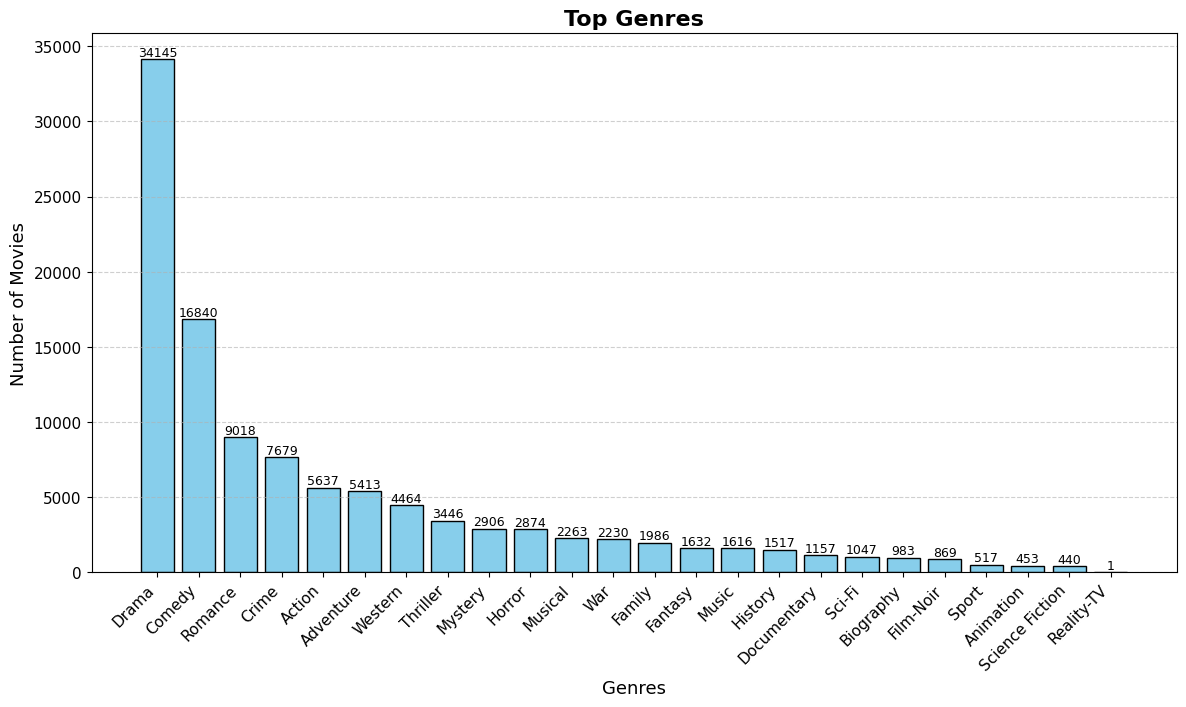

In [23]:
from collections import Counter
import matplotlib.pyplot as plt

all_genres = df['genres'].dropna().str.split(", ").sum()
genre_counts = Counter(all_genres)

top_n = 25
top_genres = genre_counts.most_common(top_n)
genres, counts = zip(*top_genres)

# Plot
plt.figure(figsize=(14, 7))
bars = plt.bar(genres, counts, color='skyblue', edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{height}', 
             ha='center', va='bottom', fontsize=9)

plt.title(f"Top Genres", fontsize=16, weight='bold')
plt.xlabel("Genres", fontsize=13)
plt.ylabel("Number of Movies", fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [24]:
# Define genre mappings (keys are variants, values are normalized genres)
genre_mapping = {
    "sci-fi": "Science Fiction",
    "science fiction": "Science Fiction",
    "musical": "Music",
    "music": "Music",
    "sport": "Sports",
}

def normalize_genres(genre_str):
    if pd.isna(genre_str):
        return None
    genres = genre_str.split(",")
    normalized = set()
    for g in genres:
        g_clean = g.strip().lower()
        normalized.add(genre_mapping.get(g_clean, g.strip().title()))  # .title() for consistent casing
    return ", ".join(sorted(normalized))

def map_special_genres(genre_str):
    if pd.isna(genre_str):
        return None
    genres = set([g.strip() for g in genre_str.split(",") if g.strip()])

    # Expand "Film-Noir"
    if "Film-Noir" in genres:
        genres.remove("Film-Noir")
        genres.update(["Crime", "Mystery", "Action"])

    # Replace "Western" with "Action"
    if "Western" in genres:
        genres.remove("Western")
        genres.add("Action")

    return ", ".join(sorted(genres))

# Apply both normalization and special mappings in order
df["genres"] = df["genres"].apply(normalize_genres)
df["genres"] = df["genres"].apply(map_special_genres)

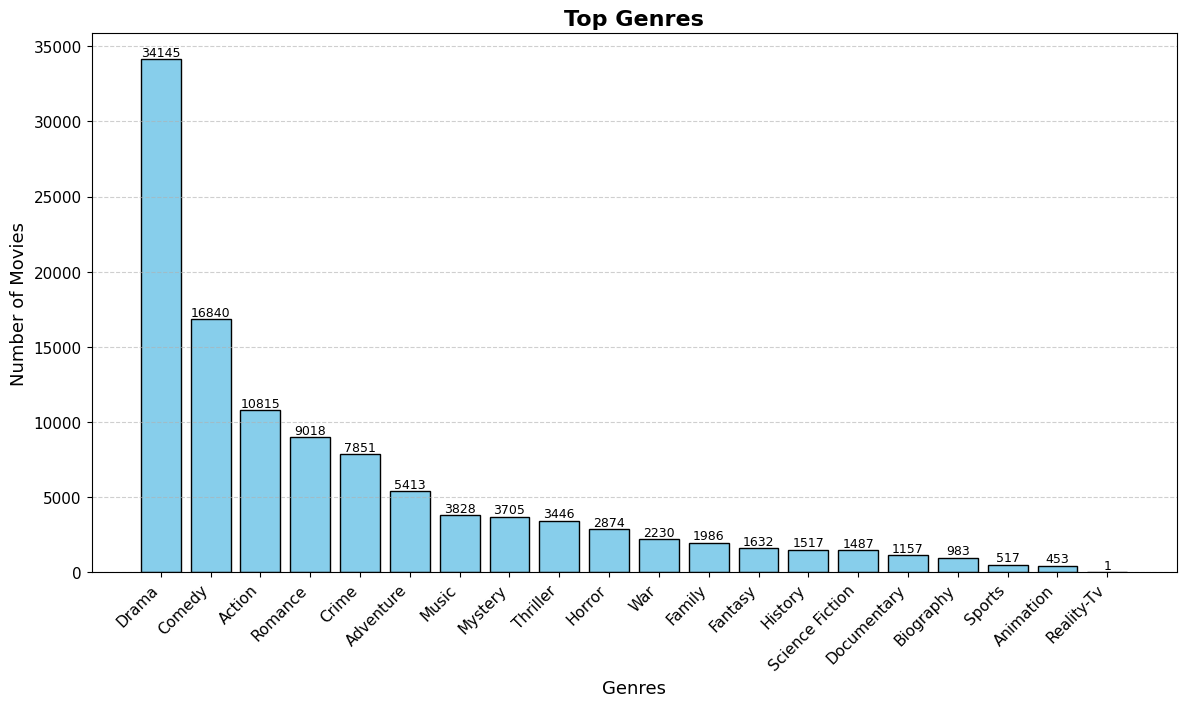

In [17]:
all_genres = df['genres'].dropna().str.split(", ").sum()
genre_counts = Counter(all_genres)

top_n = 30
top_genres = genre_counts.most_common(top_n)
genres, counts = zip(*top_genres)

# Plot
plt.figure(figsize=(14, 7))
bars = plt.bar(genres, counts, color='skyblue', edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{height}', 
             ha='center', va='bottom', fontsize=9)

plt.title(f"Top Genres", fontsize=16, weight='bold')
plt.xlabel("Genres", fontsize=13)
plt.ylabel("Number of Movies", fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()